# Mean-field simulations of mean- vs fluctuation-driven multistability

## Dynamics

$$\alpha_r\left(\Theta^t\right) = 
\int_{x}\mathcal{N}\left(x; \mu_r, \sigma_r\right) \prod_{r'\neq r} \Phi\left(x; \mu_{r'}, \sigma_{r'}\right)$$

$$\mu_r = R \sum_{r'} \mu_J(r,r') \Theta_{r'}^t + u_r^t \quad \quad \sigma^2_r = R \sum_{r'} \sigma_J^2(r,r') \Theta_{r'}^t + v_r^t$$

Infinite networks

$$\Theta^{t+1} = \boldsymbol{\alpha}(\Theta^t)$$

Finite networks

$$N\Theta^{t+1} \sim \textrm{Multinomial}\left(\boldsymbol{\alpha}(\Theta^t), N\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -200
X_MAX = 200

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

## Mean-based self-coupled network

In [3]:
D = 16
mself = np.eye(D, dtype=bool)

MU_J_SELFS = [0, 1.5, 3, 4.5]
MU_J_CROSS = 0
SGM_J_SELF = 1
SGM_J_CROSS = 1

ths_all = []

for MU_J_SELF in MU_J_SELFS:
    sys.stdout.write('.')

    MU_J = np.nan*np.zeros((D, D))
    SGM_J = np.nan*np.zeros((D, D))

    MU_J[mself] = MU_J_SELF
    MU_J[~mself] = MU_J_CROSS

    SGM_J[mself] = SGM_J_SELF
    SGM_J[~mself] = SGM_J_CROSS

    th_0 = 1 + .05*np.random.rand(D)
    th_0 /= th_0.sum()

    t_max = 100
    t = np.arange(t_max)

    ths = np.nan*np.zeros((t_max, D))
    ths[0, :] = th_0

    for t_ in t[1:]:
        ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)
        
    ths_all.append(ths)

....

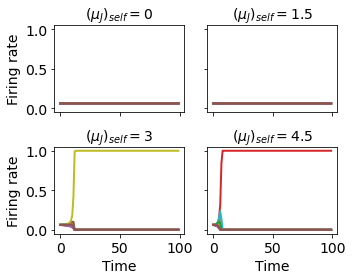

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), tight_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
for ax, ths, MU_J_SELF in zip(axs, ths_all, MU_J_SELFS):
    ax.plot(ths, lw=2)
    if ax in (axs[0], axs[2]):
        ax.set_ylabel('Firing rate')
    if ax in (axs[2], axs[3]):
        ax.set_xlabel('Time')
    set_plot(ax, title=r'$(\mu_J)_{self} = $' + f'{MU_J_SELF}', font_size=14)
    
fig.savefig('figs/main/3_multi_mean_mft.svg')

## Variance-based self-coupled network

In [5]:
D = 16
mself = np.eye(D, dtype=bool)

MU_J_SELF = 0
MU_J_CROSS = 0
SGM_J_SELFS = [1, 5, 9, 13]
SGM_J_CROSS = 1

ths_all = []

for SGM_J_SELF in SGM_J_SELFS:
    sys.stdout.write('.')

    MU_J = np.nan*np.zeros((D, D))
    SGM_J = np.nan*np.zeros((D, D))

    MU_J[mself] = MU_J_SELF
    MU_J[~mself] = MU_J_CROSS

    SGM_J[mself] = SGM_J_SELF
    SGM_J[~mself] = SGM_J_CROSS

    th_0 = 1 + .05*np.random.rand(D)
    th_0 /= th_0.sum()

    t_max = 100
    t = np.arange(t_max)

    ths = np.nan*np.zeros((t_max, D))
    ths[0, :] = th_0

    for t_ in t[1:]:
        ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)
        
    ths_all.append(ths)

....

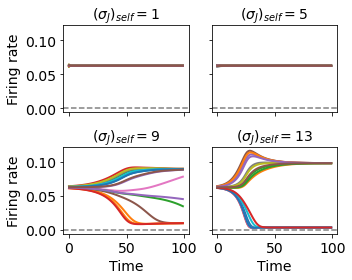

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), tight_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
for ax, ths, SGM_J_SELF in zip(axs, ths_all, SGM_J_SELFS):
    ax.plot(ths, lw=2)
    if ax in (axs[0], axs[2]):
        ax.set_ylabel('Firing rate')
    if ax in (axs[2], axs[3]):
        ax.set_xlabel('Time')
    ax.axhline(0, color='gray', ls='--')
    set_plot(ax, title=r'$(\sigma_J)_{self} = $' + f'{SGM_J_SELF}', font_size=14)
    
fig.savefig('figs/main/3_multi_fluc_mft.svg')